In [ ]:
!git clone https://github.com/billyhjm/PHM_Education.git

In [ ]:
cd /content/PHM_Education

# Resampling, Order analysis, TSA Practice

In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np

from scipy import signal, stats
from scipy.signal import hilbert
from scipy.signal import lfilter
from scipy.interpolate import interp1d

import z_dependancy as z_dep

plt.rc('font', size=20)

## 신호 생성

In [2]:
fs = 1000;
T = 20;
t = np.arange(1/fs,T+1/fs,1/fs);
n_gear = 3

w_rot = 1+t

In [3]:
phase_deg = np.cumsum(w_rot)*360/fs
phase_rad = 2*np.pi*phase_deg/360
v = np.sin(n_gear*phase_rad);

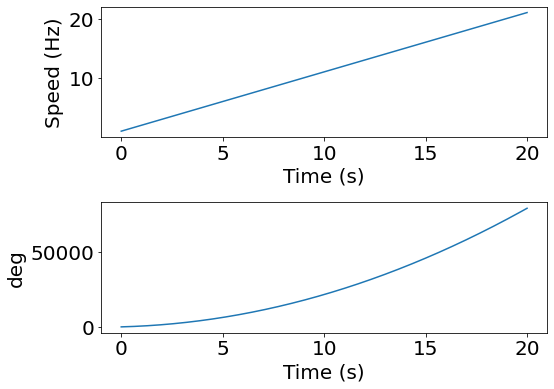

In [4]:
plt.figure(figsize=(8,6))
plt.subplot(211)
plt.plot(t,w_rot);
plt.xlabel('Time (s)');plt.ylabel('Speed (Hz)')
plt.subplot(212)
plt.plot(t,phase_deg)
plt.xlabel('Time (s)');plt.ylabel('deg')
plt.subplots_adjust(hspace=0.5)

Text(0, 0.5, 'v')

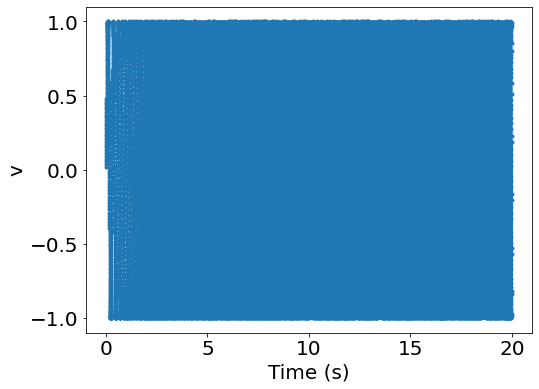

In [5]:
plt.figure(figsize=(8,6))
plt.plot(t,v,'.-');
plt.xlabel('Time (s)');plt.ylabel('v')

(0.0, 5.0)

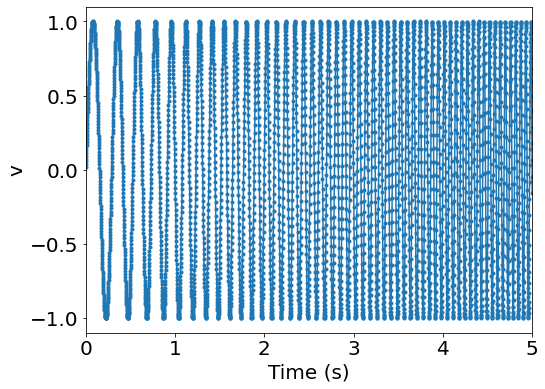

In [6]:
plt.figure(figsize=(8,6))
plt.plot(t,v,'.-');
plt.xlabel('Time (s)');plt.ylabel('v')
plt.xlim([0, 5])

## 주파수 분석

Text(0, 0.5, 'Y')

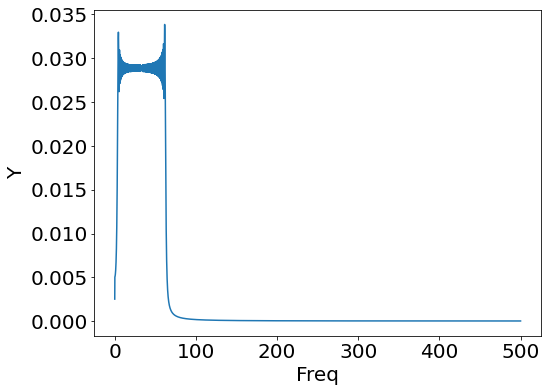

In [7]:
[f, A] = z_dep.z_fft_simple(v,fs);
plt.figure(figsize=(8,6))
plt.plot(f,A)
plt.xlabel('Freq');plt.ylabel('Y')

## Resampling Frequency 결정

### 데이터에서 계산해도 되고, 그냥 정해줘도 됨

In [8]:
Nrot = phase_deg[-1]/360
Nsamples = len(v)
fs_re = np.floor(Nsamples/Nrot)

print('# of Rotations are {:.2f}'.format(Nrot))
print('# of Samples are {:.0f}'.format(Nsamples))
print('# of Samples per rotation are {:.2f}'.format(fs_re))

# of Rotations are 220.01
# of Samples are 20000
# of Samples per rotation are 90.00


In [9]:
fs_re = 100

## Resampling 코드 짜보기

In [10]:
starting = phase_deg[0]
ending = phase_deg[-1]

In [11]:
degree_re_delta = 360 / fs_re

In [12]:
degree_re = np.arange(starting + degree_re_delta,  ending,  degree_re_delta)

degree_re[0:4]

array([ 3.96036,  7.56036, 11.16036, 14.76036])

In [13]:
degree_re[-7:-1]

array([79178.76036, 79182.36036, 79185.96036, 79189.56036, 79193.16036,
       79196.76036])

In [14]:
fx_t_re = interp1d(phase_deg, t);
t_re=fx_t_re(degree_re)

fx_v_re = interp1d(t, v);
v_re=fx_v_re(t_re)

Order analysis


In [15]:
[order, order_A] = z_dep.z_fft_simple(v_re,fs_re);

plt.figure(figsize=(8,6))
plt.subplot(121);plt.stem(order,order_A);plt.xlabel('Order');plt.ylabel('Y')
plt.subplot(122);plt.stem(order,order_A);plt.xlim([2,4]);plt.xlabel('Order');plt.ylabel('Y')

Text(0, 0.5, 'Y')

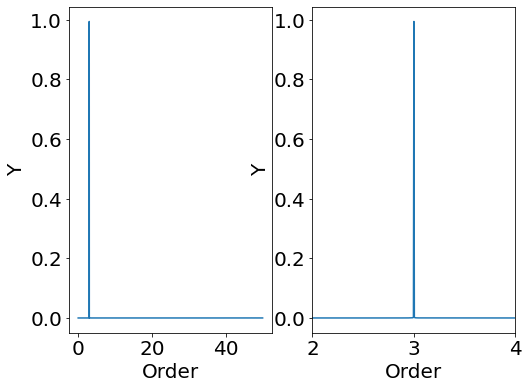

In [16]:
plt.figure(figsize=(8,6))
plt.subplot(121);plt.plot(order,order_A);plt.xlabel('Order');plt.ylabel('Y')
plt.subplot(122);plt.plot(order,order_A);plt.xlim([2,4]);plt.xlabel('Order');plt.ylabel('Y')

## Resampling - Trig=0

신호 전체 길이가 정확히 회전수의 정배수가 아니다 => 주파수 해상도가 소수점

In [17]:
trig = 0
[t_re, v_re, degree_re, fs_re]=z_dep.z_resampling(t,v,phase_deg,fs_re,trig)
N_re=len(v_re)
print(N_re)

21999


## Order analysis

Text(0, 0.5, 'Y')

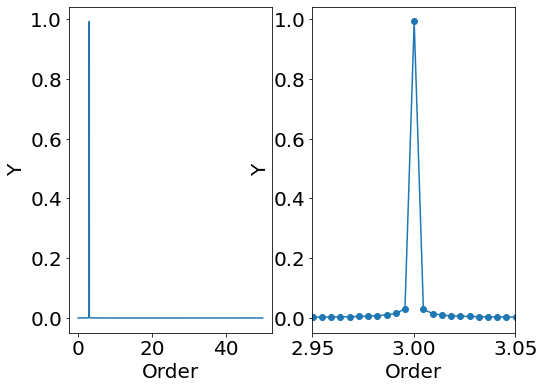

In [18]:
order, order_A = z_dep.z_fft_simple(v_re,fs_re);
plt.figure(figsize=(8,6))
plt.subplot(121);plt.plot(order,order_A);plt.xlabel('Order');plt.ylabel('Y')
plt.subplot(122);plt.plot(order,order_A,'-o');plt.xlim([2.95,3.05]);plt.xlabel('Order');plt.ylabel('Y')

## 해결방법 1: Zero-padding으로 회전수 정수배를 채워주자

In [19]:
v_re_pad = np.append(v_re, (np.zeros(fs_re-np.mod(N_re,fs_re))))
len(v_re_pad)

22000

Text(0, 0.5, 'Y')

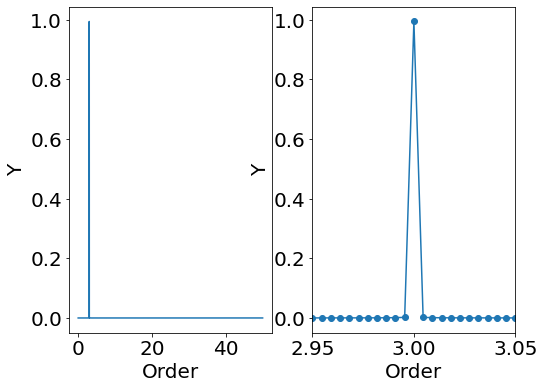

In [20]:
order, order_A = z_dep.z_fft_simple(v_re_pad,fs_re);
plt.figure(figsize=(8,6))
plt.subplot(121);plt.plot(order,order_A);plt.xlabel('Order');plt.ylabel('Y')
plt.subplot(122);plt.plot(order,order_A,'-o');plt.xlim([2.95,3.05]);plt.xlabel('Order');plt.ylabel('Y')

## 해결방법 2: 회전수 정수배가 되도록 신호 마지막을 버려주자
## Resampling - Trig=1 -> 정확히 n 바퀴에 해당하는 진동 신호만 추출

In [21]:
trig = 1
t_re, v_re, degree_re, fs_re=z_dep.z_resampling(t,v,phase_deg,fs_re,trig)
N_re=len(v_re)
print(N_re)

21900


Order analysis


Text(0, 0.5, 'Y')

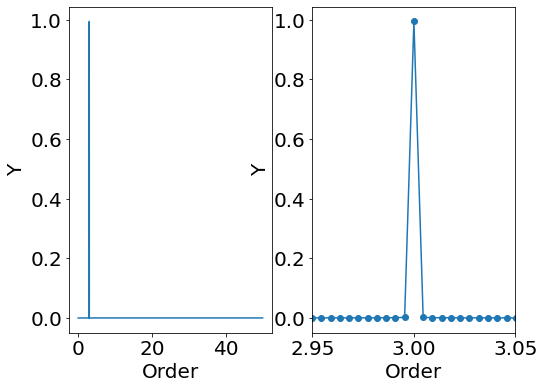

In [22]:
order, order_A = z_dep.z_fft_simple(v_re,fs_re)
plt.figure(figsize=(8,6))
plt.subplot(121);plt.plot(order,order_A);plt.xlabel('Order');plt.ylabel('Y')
plt.subplot(122);plt.plot(order,order_A,'-o');plt.xlim([2.95,3.05]);plt.xlabel('Order');plt.ylabel('Y')

# TSA 및 고장진단

## 신호생성
### 만약 신호 안에 주기적으로 (기어 1바퀴당 1번의) 이상치가 있었다면

(0.0, 1000.0)

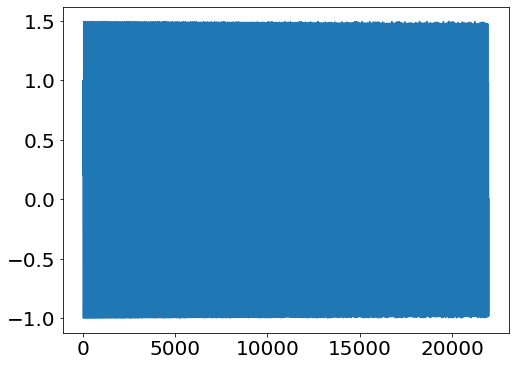

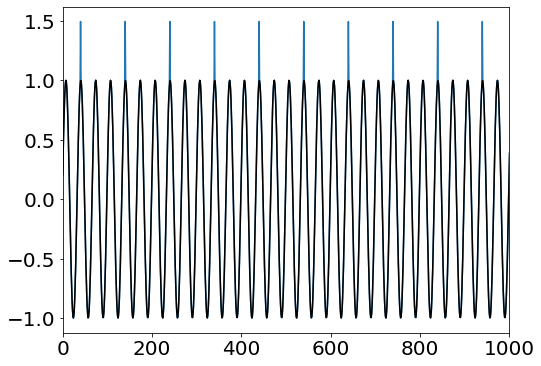

In [23]:
v_re_f = np.copy(v_re_pad)
v_re_n = np.copy(v_re_f)
idx_tmp=np.arange(40,len(v_re_f),fs_re)
v_re_f[idx_tmp] = v_re_f[idx_tmp] + 0.5

plt.figure(figsize=(8,6))
plt.plot(v_re_f)
plt.figure(figsize=(8,6))
plt.plot(v_re_f)
plt.plot(v_re_n,'k')
plt.xlim([0, 1000])

## 그런데 이 이상치들이 노이즈에 가려졌다면?

In [24]:
# Fix the random seed for reproducibility
np.random.seed(1000)
v_re_f = v_re_f+np.random.randn(np.size(v_re_f))/2;
v_re_n = v_re_n+np.random.randn(np.size(v_re_n))/2;

(0.0, 1000.0)

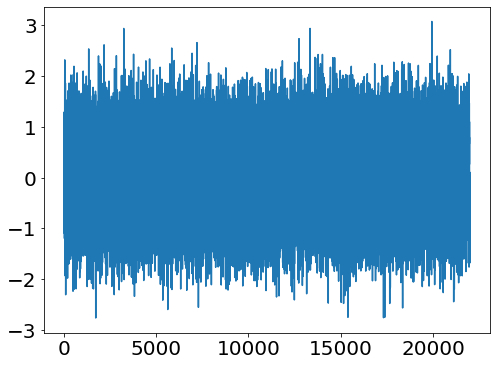

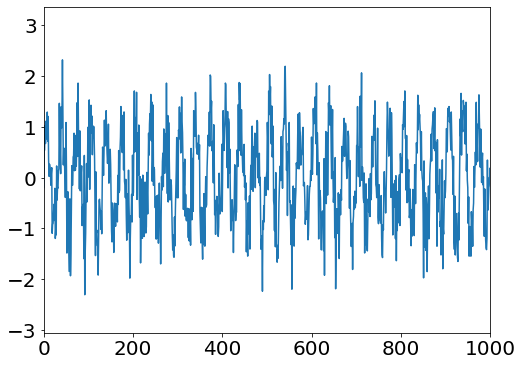

In [25]:
plt.figure(figsize=(8,6))
plt.plot(v_re_f)
plt.figure(figsize=(8,6))
plt.plot(v_re_f)
plt.xlim([0, 1000])

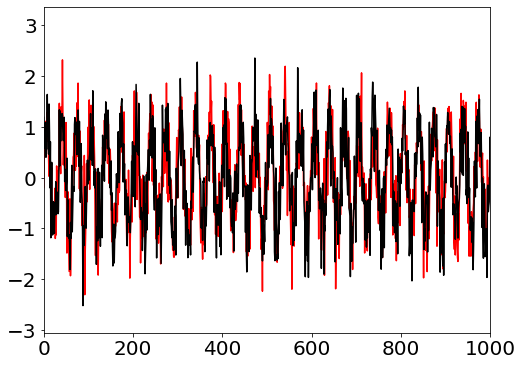

In [26]:
plt.figure(figsize=(8,6))
plt.plot(v_re_f,'r'); plt.plot(v_re_n,'k')
plt.xlim([0,1000])
plt.show()

## 신호를 잘라서 평균화

In [27]:
n_rot_TSA = 5
v_reshape_f = v_re_f.reshape(n_rot_TSA*fs_re, -1,  order="F")
v_TSA_f = np.mean(v_reshape_f,1)
np.shape(v_reshape_f)

(500, 44)

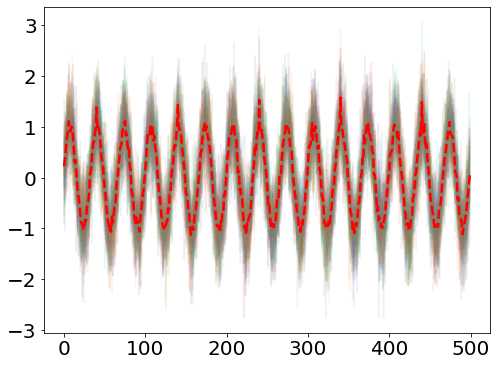

In [28]:
plt.figure(figsize=(8,6))
plt.plot(v_reshape_f, alpha=0.1)
plt.plot(v_TSA_f,'r--',linewidth=2.5)

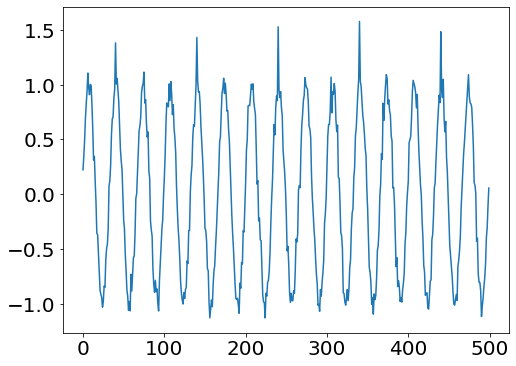

In [29]:
plt.figure(figsize=(8,6))
plt.plot(v_TSA_f)

## 여기서 다시 Feature를 뽑아보자
### 일단 비교를 위해 정상 데이터도 만들어 주고

In [30]:
v_reshape_n = v_re_n.reshape(n_rot_TSA*fs_re, -1,  order="F")
v_TSA_n = np.mean(v_reshape_n,1)

### Plot Data

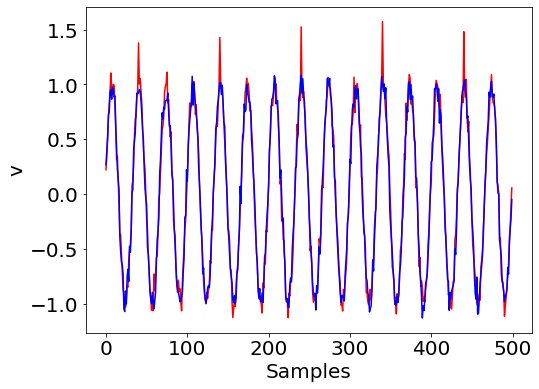

In [31]:
plt.figure(figsize=(8,6))
plt.plot(v_TSA_f,'r')
plt.plot(v_TSA_n,'b')
plt.xlabel('Samples');plt.ylabel('v')
plt.show()

### 주파수 분석해보기


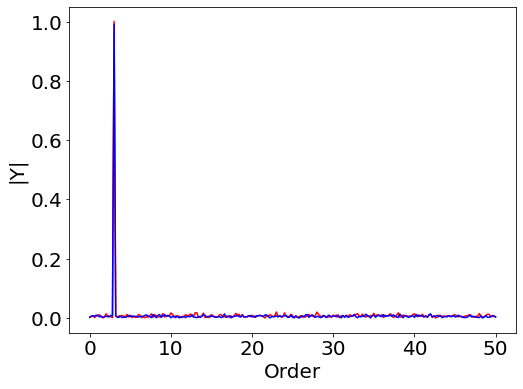

In [32]:
f_n, A_n = z_dep.z_fft_simple(v_TSA_n,fs_re)
f_f, A_f = z_dep.z_fft_simple(v_TSA_f,fs_re)
plt.figure(figsize=(8,6))
plt.plot(f_f,A_f,'r')
plt.plot(f_n, A_n, 'b')
plt.xlabel('Order');plt.ylabel('|Y|')
plt.show()

Text(0, 0.5, '|Y|')

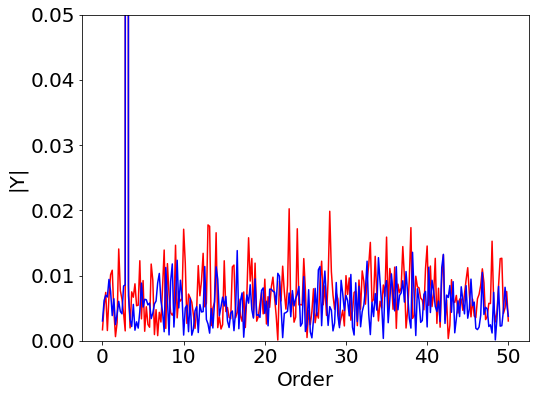

In [33]:
plt.figure(figsize=(8,6))
plt.plot(f_f,A_f,'r')
plt.plot(f_n, A_n, 'b');plt.ylim([0,0.05])
plt.xlabel('Order');plt.ylabel('|Y|')

### 필터링 후 분석 해보기

Filter Design and Filtering


[10]


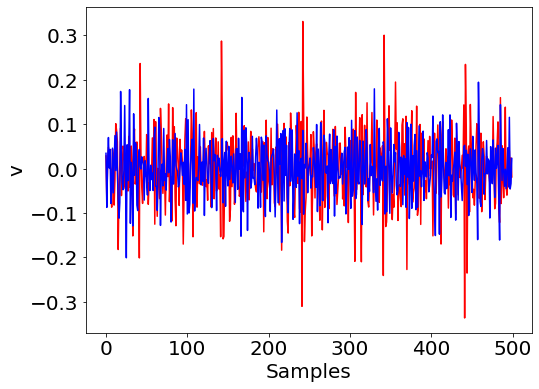

In [51]:
ftype='high'
Wn=np.array([10])
print(Wn)
v_high_n = z_dep.filtering(v_TSA_n, fs_re, Wn, ftype)
v_high_f = z_dep.filtering(v_TSA_f, fs_re, Wn, ftype)

plt.figure(figsize=(8,6))
plt.plot(v_high_f,'r')
plt.plot(v_high_n,'b')
plt.xlabel('Samples');plt.ylabel('v')
plt.show()

### 필터링 신호의 Residual 보기

In [52]:
v_res = abs(hilbert(v_high_f)) - abs(hilbert(v_high_n))
v_res = abs(hilbert(v_res))

Text(0, 0.5, 'residual')

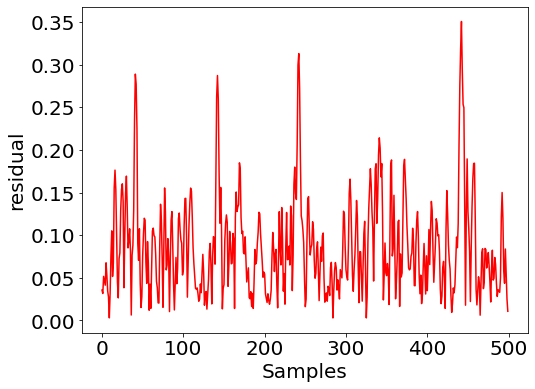

In [53]:
plt.figure(figsize=(8,6))
plt.plot(v_res,'r')
plt.xlabel('Samples');plt.ylabel('residual')

### Feature 추출해보기


In [54]:
band_energy_and_filter = [10,49]
band_enrgy_from_envelope = np.matrix([
                [3*0.9, 3*1.1],
                [2*3*0.9, 2*3*1.1],
                [3*3*0.9, 3*3*1.1]
                ])

print(f'Band Energy and Filter Range: {band_energy_and_filter}')
print(f'Band Energy from Envelope: {band_enrgy_from_envelope}')

Band Energy and Filter Range: [10, 49]
Band Energy from Envelope: [[2.7 3.3]
 [5.4 6.6]
 [8.1 9.9]]


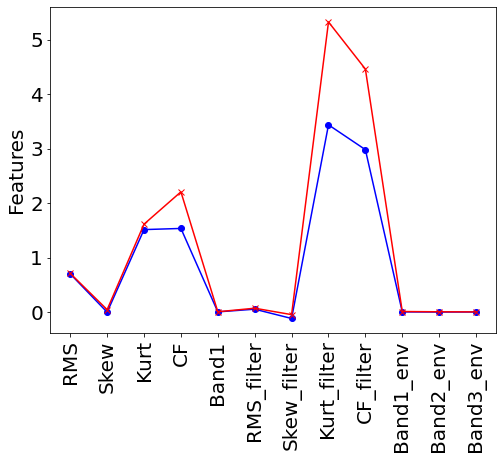

In [55]:
feature_n, feature_name = z_dep.z_feature(v_TSA_n, fs_re, band_energy_and_filter, band_enrgy_from_envelope)
feature_f, feature_name = z_dep.z_feature(v_TSA_f, fs_re, band_energy_and_filter, band_enrgy_from_envelope)

plt.figure(figsize=(8,6))
plt.plot(feature_n,'-bo')
plt.plot(feature_f,'-rx')
plt.xticks(np.arange(0,np.size(feature_name)),feature_name,rotation='vertical')
plt.ylabel('Features')
plt.show()

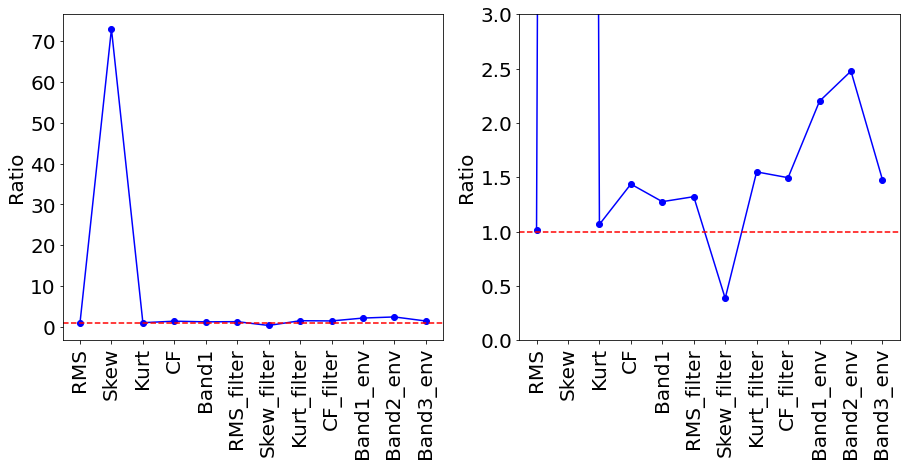

In [56]:
feature_ratio = feature_f/feature_n

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(feature_ratio,'-bo')
plt.xticks(np.arange(0,np.size(feature_name)),feature_name,rotation='vertical')
plt.axhline(y=1, color='r', linestyle='--')
plt.ylabel('Ratio')

plt.subplot(1,2,2)
plt.plot(feature_ratio,'-bo')
plt.xticks(np.arange(0,np.size(feature_name)),feature_name,rotation='vertical')
plt.axhline(y=1, color='r', linestyle='--')
plt.ylim([0,3])
plt.ylabel('Ratio')
plt.show()